# Course assessment 
## Numerical processing of financial data MAP542 

Stefano De Marco

#### Objective
The goal of this project is to fit some implied volatility parametrisations to market option data while studying their no-arbitrage properties.

- Please write commented code. You can also use text cells for your comments and explanations.
- The code must follow the good coding principles (it must be clean, readable, etc.). 
- Graphs must have a title, a legend and their axes must be labeled. 
- At the end, submit your notebooks and a pdf file of 5 to 8 pages into the Moodle Assignment you will find in "Assessment part II". In the pdf file, you are asked to explain the procedure you have followed to complete the given tasks, and present/discuss your results (being they positive or negative).

#### Modules

Feel free to add any other (open-source) module you need.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. The SVI parameterisation for the implied volatility

### Part 1.1 

$\blacktriangleright$ __TO DO__: Complete and submit the notebook "Notebook_9_no_arbitrage_implied_vol.ipynb"

### Part 1.2

$\blacktriangleright$ __New dataset__ : you can download delayed option quotes on the SP500 index from the [CBOE quotes platform](http://www.cboe.com/delayedquote/quote-table) (index symbol: SPX). 
 
$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the standard maturities for SPX options being the third Friday of each month), filter out quotes that have zero volume, and perform a fitting (learning) of the SVI model parameters as done in Notebook 9. 
If you wish to use yet another set of option prices (e.g. on another asset), this is also possible. In any case, provide the dataset together with your notebook.

$\blacktriangleright$ Try to take into account the no-arbitrage conditions within the parameter learning process (or at least, after the learning process).

Explain in details the procedure you have followed, and present/discuss your results.

$\blacktriangleright$ __New dataset__ : you can download delayed option quotes on the SP500 index from the [CBOE quotes platform](http://www.cboe.com/delayedquote/quote-table) (index symbol: SPX). 
 
$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the standard maturities for SPX options being the third Friday of each month), filter out quotes that have zero volume, and perform a fitting (learning) of the SVI model parameters as done in Notebook 9. 
If you wish to use yet another set of option prices (e.g. on another asset), this is also possible. In any case, provide the dataset together with your notebook.


In [21]:
df = pd.read_csv('spx_quotedata.csv', skiprows=2)

df.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
0,Fri Apr 19 2024,SPX240419C01900000,3252.29,-21.2599,3263.0,3270.3,1,0.0,1.0000,0.0,...,SPX240419P01900000,0.15,0.000,0.0,0.10,0,0.9307,-0.0002,0.0,5731
1,Fri Apr 19 2024,SPX240419C02000000,3160.06,-14.1401,3163.5,3170.9,1,0.0,1.0000,0.0,...,SPX240419P02000000,0.05,0.000,0.0,0.10,1,0.8845,-0.0002,0.0,5883
2,Fri Apr 19 2024,SPX240419C02200000,0.00,0.0000,2965.0,2972.3,0,0.0,1.0000,0.0,...,SPX240419P02200000,0.07,0.020,0.0,0.15,3,0.8214,-0.0003,0.0,4213
3,Fri Apr 19 2024,SPX240419C02300000,0.00,0.0000,2865.2,2872.5,0,0.0,1.0000,0.0,...,SPX240419P02300000,0.10,0.025,0.0,0.15,10,0.7805,-0.0004,0.0,5048
4,Fri Apr 19 2024,SPX240419C02350000,0.00,0.0000,2815.5,2822.8,0,0.0,0.9999,0.0,...,SPX240419P02350000,0.10,0.050,0.0,0.15,30,0.7607,-0.0004,0.0,1964


In [22]:
df.drop(columns=['Expiration Date', 'Calls', 'Puts'], inplace=True)
df.head()

,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
0,3252.29,-21.2599,3263.0,3270.3,1,0.0,1.0000,0.0,2,1900.0,0.15,0.000,0.0,0.10,0,0.9307,-0.0002,0.0,5731
1,3160.06,-14.1401,3163.5,3170.9,1,0.0,1.0000,0.0,51,2000.0,0.05,0.000,0.0,0.10,1,0.8845,-0.0002,0.0,5883
2,0.00,0.0000,2965.0,2972.3,0,0.0,1.0000,0.0,0,2200.0,0.07,0.020,0.0,0.15,3,0.8214,-0.0003,0.0,4213
3,0.00,0.0000,2865.2,2872.5,0,0.0,1.0000,0.0,0,2300.0,0.10,0.025,0.0,0.15,10,0.7805,-0.0004,0.0,5048
4,0.00,0.0000,2815.5,2822.8,0,0.0,0.9999,0.0,0,2350.0,0.10,0.050,0.0,0.15,30,0.7607,-0.0004,0.0,1964


Convert the DataFrame to a numpy array

In [23]:
quotes = df.to_numpy()

In [25]:
strikes = quotes[:, 9]

call_bid = quotes[:, 2]
call_ask = quotes[:, 3]

put_bid = quotes[:, 12]
put_ask = quotes[:, 13]

# Evaluate the call and put mid prices that we 
# will use as reference prices
call_prices = (call_bid + call_ask) / 2
put_prices = (put_bid + put_ask) / 2

# Observation date: Mar 15, 2024
# Expiration Date : Fri Apr 19, 2024
# ---> time to maturity = 35 days
maturity = 35/365

print("quotes.shape :", quotes.shape)
print("\n Strikes: ", strikes)
print("Call prices: ", call_prices)
print("Put prices: ", put_prices, "\n")

print("Maturity (in years): %1.3f" %maturity)

quotes.shape : (280, 19)

 Strikes:  [1900. 2000. 2200. 2300. 2350. 2400. 2450. 2800. 2825. 2850. 2875. 2900.
 2925. 2950. 2975. 3000. 3025. 3050. 3075. 3100. 3125. 3150. 3175. 3200.
 3225. 3250. 3275. 3300. 3325. 3350. 3375. 3400. 3425. 3450. 3475. 3500.
 3525. 3550. 3560. 3575. 3580. 3600. 3625. 3650. 3660. 3675. 3700. 3725.
 3750. 3775. 3790. 3800. 3825. 3850. 3875. 3900. 3925. 3950. 3975. 4000.
 4025. 4030. 4040. 4050. 4060. 4075. 4090. 4100. 4125. 4140. 4150. 4160.
 4175. 4180. 4190. 4200. 4225. 4240. 4250. 4260. 4275. 4280. 4290. 4300.
 4310. 4325. 4330. 4350. 4360. 4375. 4380. 4400. 4420. 4425. 4430. 4440.
 4450. 4455. 4460. 4475. 4480. 4490. 4495. 4500. 4510. 4520. 4525. 4530.
 4535. 4540. 4550. 4555. 4560. 4565. 4570. 4575. 4580. 4585. 4590. 4600.
 4605. 4610. 4615. 4620. 4625. 4640. 4650. 4655. 4660. 4675. 4680. 4685.
 4690. 4700. 4705. 4715. 4725. 4730. 4740. 4745. 4750. 4755. 4760. 4765.
 4770. 4775. 4780. 4790. 4800. 4805. 4810. 4820. 4825. 4830. 4835. 4840.
 4845. 4850. 4

Let us have a look at the price quotes

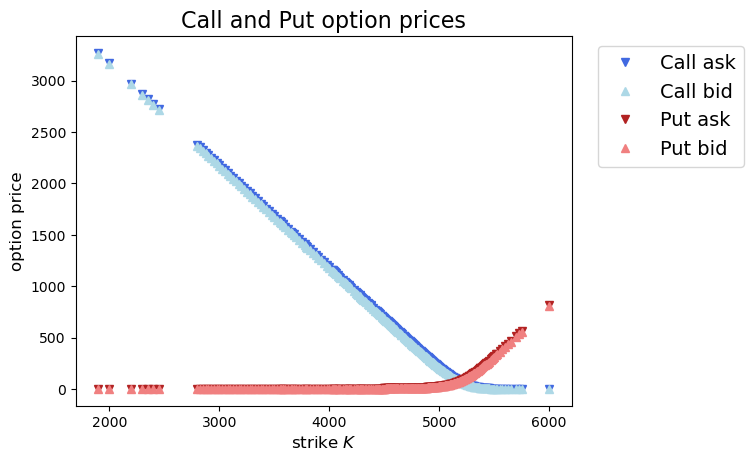

In [26]:
plt.plot(strikes, call_ask, color='royalblue', linewidth=0., marker="v", label="Call ask")
plt.plot(strikes, call_bid, color='lightblue', linewidth=0., marker="^", label="Call bid")

plt.plot(strikes, put_ask, color='firebrick', linewidth=0., marker="v", label="Put ask")
plt.plot(strikes, put_bid, color='lightcoral', linewidth=0., marker="^", label="Put bid")

plt.xlabel("strike $K$", fontsize=12)
plt.ylabel("option price", fontsize=12)
plt.title("Call and Put option prices", fontsize=16)

plt.legend(loc=9, fontsize=14, bbox_to_anchor=(1.2, 1.0), ncol=1)
plt.show()

Let's perform a linear regression so to determine the discount factor and the forward value

We determine the slope $b$ and the intercept $a$ of the linear function that best interpolates the values of $\mathrm{Call}(K) - \mathrm{Put}(K)$:

$$
\mathrm{Call}(K) - \mathrm{Put}(K) \approx f(K) = a + b \, K.
$$

This gives a way of setting the discount factor and the forward for the maturity $T$ we are working with:

$$
D(0,T) = e^{-rT} \quad \text{and} \quad F_0^T = \frac{-a}{b} \quad \text{(in terms of $a$ and $b$)}
$$


In [27]:
import scipy.stats as sps

function linregress of scipy.stats to regress the values of  Call(K) - Put(K) against the strikes 

In [34]:
call_minus_put = call_prices - put_prices

(slope, intercept, rvalue, other_value1, other_value2) = sps.linregress(strikes, call_minus_put)


print("Slope = %1.3f" %slope)
print("Intercept =: %1.2f" %intercept)
print("Correlation coefficient = %1.12f \n" %rvalue)

Slope = -0.994
Intercept =: 5155.95
Correlation coefficient = -0.999999983699 



In [35]:
discount_factor = -slope

F_T = intercept / discount_factor

print("Therefore: \n")
print("D(0,T) = %1.3f" %discount_factor)
print("Forward value F_T = %1.2f" %F_T)

Therefore: 

D(0,T) = 0.994
Forward value F_T = 5184.85


We are now in a good position to evaluate the implied volatility associated with option prices. Recall that the market implied volatility, $\sigma(T,K)$, for a given maturity $T$ and strike price $K$, is the unique solution to the equation:

$$
\text{Call}^{\text{mkt}}(T,K) = \text{Call}_{\text{BS}}(T, K, F_0^T, D(0,T), \sigma(T,K)),
$$

where $\text{Call}_{\text{BS}}(T, K, F, D, \sigma)$ denotes the call price as determined by the Black-Scholes formula for a maturity $T$, a strike price $K$, a forward value $F$, a discount factor $D = e^{-rT}$, and a volatility $\sigma$.

In this framework, the market implied volatility is crucial for capturing the expected fluctuations in the option's underlying asset price over time. It is derived by equating the market-observed call price, $\text{Call}^{\text{mkt}}(T,K)$, with the theoretical call price from the Black-Scholes model, $\text{Call}_{\text{BS}}$, given the existing parameters and the sought-after volatility $\sigma(T,K)$. This calculation offers valuable insights into the market's perceptions and the pricing dynamics of financial derivatives.


In [36]:
from BlackScholesFunctions import Put_BS_core, volImplCore_Newton, volImplPutCore_bisection

Implied vol from puts

In [37]:
vols_puts = np.zeros(strikes.size)

for i in range(strikes.size):
    K = strikes[i]
    
    vol, iterations = volImplCore_Newton(tau = maturity, K = K, DF = discount_factor, F = F_T,
                                            price = put_prices[i], # mid prices for puts
                                            CallOrPutFlag = 0,
                                            initial_point = 0.2, prix_tol = 1.e-4, max_iter=50)
    
    vols_puts[i] = vol


print("Done")

c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  vol = vol - (current_price - price) / Vega_core(tau, K, DF, F, vol)
c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  d_2 = d_1 - sigma_sqrt_tau
c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:73: RuntimeWarning: overflow encountered in scalar power
  vega = DF * F * np.sqrt(tau) * np.exp(-d_1**2 / 2) / np.sqrt(2*np.pi)


Done


Implied vol from calls

In [38]:
vols_calls = np.zeros(strikes.size)

for i in range(strikes.size):
    K = strikes[i]
    
    vol, iterations = volImplCore_Newton(tau = maturity, K = K, DF = discount_factor, F = F_T,
                                            price = call_prices[i], # mid prices for calls
                                            CallOrPutFlag = 1,
                                            initial_point = 0.2, prix_tol = 1.e-4, max_iter=50)
    
    vols_calls[i] = vol

print("Done")

c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:41: RuntimeWarning: invalid value encountered in scalar subtract
  d_2 = d_1 - sigma_sqrt_tau


Done


Let's plot the resulting smile in terms of the log-forward moneyness $k = \log(K / F_0^T)$:

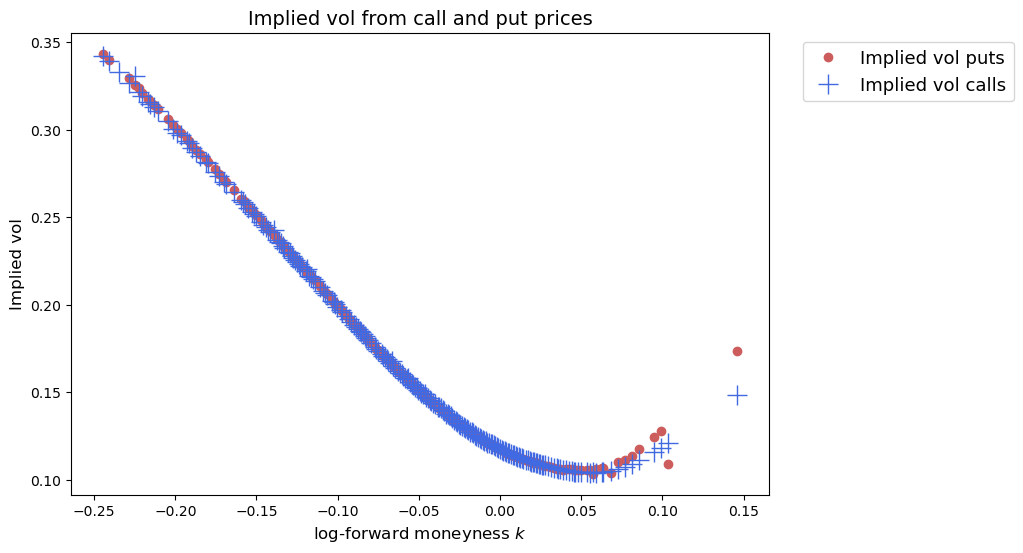

In [40]:
plt.figure(figsize=(9,6))

mkt_log_mon = np.log(strikes/F_T)

plt.plot(mkt_log_mon, vols_puts ,
         color='indianred', linewidth=0., marker=".", markersize=12, label="Implied vol puts")

plt.plot(mkt_log_mon, vols_calls ,
         color='royalblue', linewidth=0., marker="+", markersize=14, label="Implied vol calls")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Implied vol", fontsize=12)
plt.title("Implied vol from call and put prices", fontsize=14)

plt.legend(loc=9, fontsize=13, bbox_to_anchor=(1.2, 1.0), ncol=1)

Let's save all in a file to have the times aligned and to remove the nan values

In [41]:
vol_data = np.array([mkt_log_mon, vols_calls])

valid_mask = ~np.isnan(vol_data).any(axis=0) & ~np.isinf(vol_data).any(axis=0)

filtered_vol_data = vol_data[:, valid_mask]

np.savetxt("SPX_vol_quotes_2.csv", filtered_vol_data, delimiter=";")

In [43]:
quotes_corr = np.loadtxt(open("SPX_vol_quotes_2.csv", "r"), delimiter=";")

print("quotes.shape : ", quotes_corr.shape)

mkt_log_mon = quotes_corr[0]
vols_calls = quotes_corr[1]
    
maturity = 35/365

print("\n Maturity (in years): %1.2f" %maturity)

print("\n Log moneyness: ", mkt_log_mon)
print("Implied vols from calls mid prices: ", vols_calls)

quotes.shape :  (2, 215)

 Maturity (in years): 0.10

 Log moneyness:  [-2.44558893e-01 -2.40871119e-01 -2.34754892e-01 -2.28675846e-01
 -2.25046078e-01 -2.22633532e-01 -2.20226792e-01 -2.16627508e-01
 -2.15430620e-01 -2.13041132e-01 -2.10657341e-01 -2.04722605e-01
 -2.01178597e-01 -1.98822883e-01 -1.96472706e-01 -1.92957764e-01
 -1.91788857e-01 -1.89455133e-01 -1.87126843e-01 -1.84803962e-01
 -1.81329726e-01 -1.80174324e-01 -1.75566021e-01 -1.73269809e-01
 -1.69835346e-01 -1.68693142e-01 -1.64137325e-01 -1.59602170e-01
 -1.58471588e-01 -1.57342282e-01 -1.55087490e-01 -1.52837770e-01
 -1.51714805e-01 -1.50593100e-01 -1.47235514e-01 -1.46118820e-01
 -1.43889164e-01 -1.42776198e-01 -1.41664469e-01 -1.39444713e-01
 -1.37229872e-01 -1.36124289e-01 -1.35019927e-01 -1.33916783e-01
 -1.32814854e-01 -1.30614633e-01 -1.29516335e-01 -1.28419243e-01
 -1.27323352e-01 -1.26228661e-01 -1.25135167e-01 -1.24042868e-01
 -1.22951760e-01 -1.21861842e-01 -1.19685563e-01 -1.18599196e-01
 -1.17514009e-01 -1

Let's use the same procedure used in Notebook 8 part 2 to fit the SVI model to the implied volatility smile

In [45]:
import scipy.optimize as opt

In [46]:
def SVI(k, a, b , rho, k_bar, sig):
    total_variance = a + b * (rho * (k - k_bar) + np.sqrt((k - k_bar)**2 + sig**2))
    
    return total_variance

def SVI_two_arguments(theta, k):
    a, b , rho, k_bar, sig = theta
    
    return SVI(k, a, b , rho, k_bar, sig)

def fct_least_squares(theta, log_mon, tot_implied_variance):
    """
    theta                : the vector of SVI parameters
    log_mon              : log-forward moneyness k (float or double)
    tot_implied_variance : the target total implied variance (float or double)
    
    Returns : the objective function (without the square) to be injected
    in the least-square problem
    """
    return SVI_two_arguments(theta, log_mon) - tot_implied_variance

In [47]:
## Recall that our target is the vector of total variances from (call or put) price quotes
mkt_tot_variance = maturity * vols_calls**2

## Choice of initial point
a_init = np.min(mkt_tot_variance) / 2
b_init = 0.1
rho_init = -0.8
k_bar_init = 0.
sig_init = 0.1

We code the bounds we impose on the SVI parameters

In [48]:
lower = np.array([0.,   # a
                  0.,   # b
                  -1.,  # rho
                  -0.5, # k_bar
                  0.])  # sigma

upper = np.array([np.max(mkt_tot_variance), # a
                  2.,  # b
                  1.,  # rho
                  0.5, # k_bar
                  1.]) # sigma

SVI_param_bounds = (lower, upper)

theta_init = np.array([a_init, b_init, rho_init, k_bar_init, sig_init])

In [49]:
result = opt.least_squares(fun = fct_least_squares ,
                           x0 = theta_init , 
                           bounds = SVI_param_bounds ,
                           args = (mkt_log_mon, mkt_tot_variance), #additional arguments for the LS objective
                           verbose = 1)

## The optimized parameters
a_star, b_star, rho_star, k_bar_star, sig_star = result.x

`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 3.2531e-02, final cost 1.0171e-06, first-order optimality 6.35e-09.


Let's plot the calibrated model

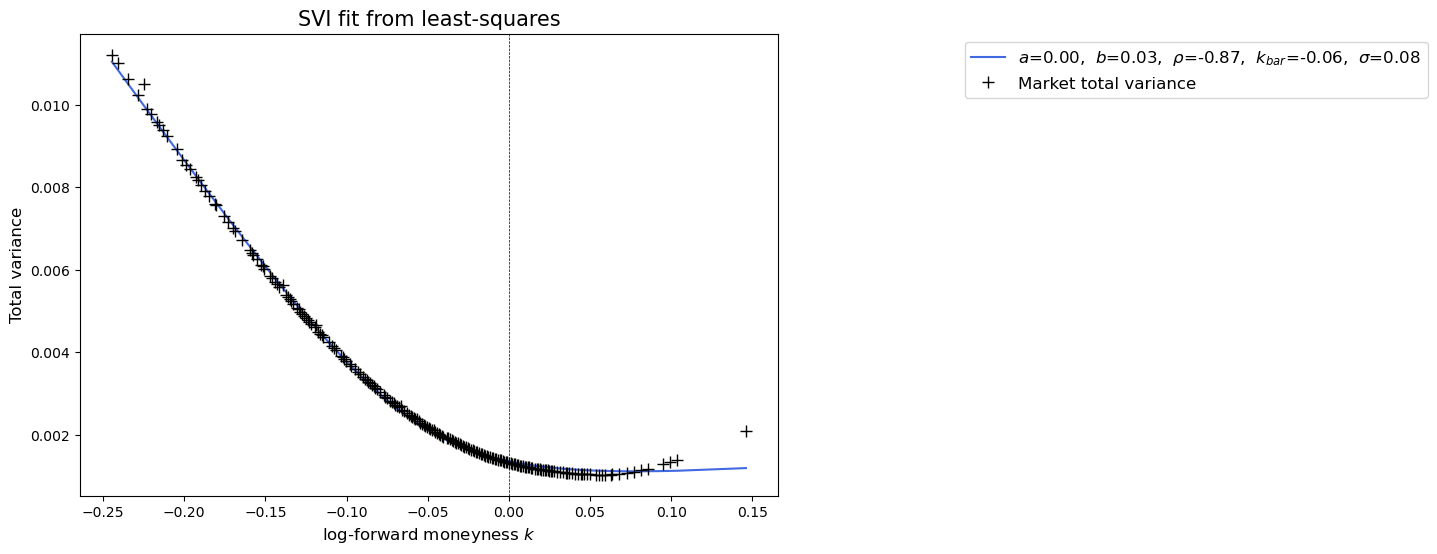

In [50]:
total_variances_fit = SVI(mkt_log_mon , a_star, b_star, rho_star, k_bar_star, sig_star)

plt.figure(figsize=(9,6))

plt.plot(mkt_log_mon, total_variances_fit,
         color='royalblue', linewidth=1.5, 
         label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_{bar}$=%1.2f,  $\sigma$=%1.2f" %(a_star, b_star, rho_star, k_bar_star, sig_star))

plt.plot(mkt_log_mon, mkt_tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")


plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"SVI fit from least-squares", fontsize=15)

plt.legend(loc=9, fontsize=12, bbox_to_anchor=(1.6, 1.0), ncol=1)

$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the standard maturities for SPX options being the third Friday of each month), filter out quotes that have zero volume, and perform a fitting (learning) of the SVI model parameters as done in Notebook 9. 
If you wish to use yet another set of option prices (e.g. on another asset), this is also possible. In any case, provide the dataset together with your notebook.


$\blacktriangleright$ Try to take into account the no-arbitrage conditions within the parameter learning process (or at least, after the learning process).

Explain in details the procedure you have followed, and present/discuss your results.

## Part 2. The SSVI ("surface SVI") sub-family

Below, you will recognize the SSVI parametric model that was presented in Notebook 9.

The SSVI parameterisation of [Gatheral and Jacquier, 2014](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323) is constructed as follows: first define the

### SSVI slice

$$
w_\mathrm{SSVI}(k) = \frac{\theta} 2 \Bigl(1 + \varphi \, \rho k + \sqrt{(\varphi \, k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R
$$

where 

$$
\theta \ge 0, \qquad \varphi \ge 0, \qquad \rho \in (-1,1).
$$

Note that $w_\mathrm{SSVI}(k) \big|_{k=0} = \theta$, so that the parameter $\theta$ corresponds to the ATM total variance.

+ Thanks to the reduced complexity (3 parameters instead of 5), the no-butterfly arbitrage conditions 1) and 3) from the lecture notes on a SSVI slice can be replaced with much simpler conditions on the parameters $(\theta, \varphi, \rho)$, given in [Gatheral and Jacquier 2014], Theorem 4.2, which states that the no-arbitrage conditions 1) and 3) are satisfied if

$$
\left\{
\begin{aligned}
&\theta \, \varphi \, (1+|\rho|) < 4
\\
&\theta \, \varphi^2 \, (1+|\rho|) \le 4.
\end{aligned}
\right.
$$

$\blacktriangleright$ __TO DO__: perform a fitting of the SSVI slice parameters (as opposed to SVI) to the market data already used in Part 1.2 (for the same fixed maturity).

Take into account the no-arbitrage conditions on the SSVI parameterisation within or after the parameter learning process. Explain in details the procedure you have followed, and present/discuss your results.

### Full SSVI surface

So far, we have only worked with fixed-maturity slices of the implied volatility surface. We haven't defined a function $w_\mathrm{SSVI}$ of $(T, k)$ yet.

Given:

+ a curve $T \mapsto \theta_T \ge 0$ (representing at-the-money total implied variance for maturity $T$)


+ a function $\varphi: \mathbb R_+ \to \mathbb R_+$,

the full __Surface SVI__ model is defined by

$$
\begin{aligned}
w_\mathrm{SSVI}(T, k) 
&= 
w_\mathrm{SSVI}(k; \ \theta_{T}, \ \varphi(\theta_T), \ \rho) 
\\
&= \frac{\theta_{T}} 2 \Bigl(1 + \varphi(\theta_{T}) \rho k + \sqrt{\bigl(\varphi(\theta_{T}\bigr) k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R, T > 0.
\end{aligned}
$$

The no-calendar spread arbitrage condition we have seen in the lectures:
  
2) The function $T \mapsto w_\mathrm{SSVI}(T, k) $ is increasing, for every $k \in \mathbb R$,

can also be reformulated as a simple condition on the functions $\theta_\cdot$ and $\varphi(\cdot)$, see [Gatheral and Jacquier 2014], Theorem 4.1:

$$
\left\{
\begin{aligned}
& T \mapsto \theta_T \text{ is increasing,} \\
& 0 \le \frac{\partial}{\partial \theta} (\theta \varphi(\theta)) \le \frac{1}{\rho^2} \left(1+ \sqrt{1-\rho^2}\right) \varphi(\theta) \quad \forall \theta,
\end{aligned}
\right.
$$

where, in the second line, we have supposed that the functions $\theta_\cdot$ and $\varphi(\cdot)$ are differentiable.

[Gatheral and Jacquier 2014] provide parametric examples of functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ that satisfy the no-calendar spread arbitrage condition above.

$\blacktriangleright$ __TO DO__: dowload and use option data for at least two different maturities $T_1$ and $T_2$ (or more if you wish), observed at the same date $t$. Make a parametric choice for the functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ and perform a fitting of the full SSVI surface model to your target maturities.

Take into account the no-arbitrage conditions on SSVI within or after the parameter learning process. Explain in details the procedure you have followed, and present/discuss your results.